# This is a notebook for Multinomial Naive Bayes training a model to be able to categorize fake vs real news.

In [1]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk 
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Make a function to apply text preprocesing to the datasets. </br>
Load the data formating it correctly for easy use and apply the preprocessing. </br>
Split the data into a label and title columns so es easy to access only the title for training.

In [3]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra white space
    text = text.strip()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [4]:
# Load the datasets formating them correctly for ease of use
train_data = pd.read_csv(
    r"../training_data_lowercase.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

test_data = pd.read_csv(
    r"../testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB separator
    header=None,
    names=['label', 'title']
)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [5]:
# Apply preprocessing to the 'title' column
train_data['title'] = train_data['title'].apply(clean_text)
test_data['title'] = test_data['title'].apply(clean_text)

print(train_data['title'].head())
print(test_data['title'].head())

0    donald trump sends embarrassing new years eve ...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas speech
Name: title, dtype: object
0    copycat muslim terrorist arrested assault weapons
1    wow chicago protester caught camera admits vio...
2          germanys fdp look fill schaeubles big shoes
3    mi school sends welcome back packet warning ki...
4    un seeks massive aid boost amid rohingya emerg...
Name: title, dtype: object


Tokenice and lemmatazing to prepare the titles to convert to numbers using TF_IDF.

In [6]:
# Tokenize train and testing data
def tokenizeDataframe(text):
    tokens = word_tokenize(text)
    return tokens

train_data['title'] = train_data['title'].apply(tokenizeDataframe)
test_data['title'] = test_data['title'].apply(tokenizeDataframe)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  [donald, trump, sends, embarrassing, new, year...
1      0  [drunk, bragging, trump, staffer, started, rus...
2      0  [sheriff, david, clarke, becomes, internet, jo...
3      0  [trump, obsessed, even, obamas, name, coded, w...
4      0  [pope, francis, called, donald, trump, christm...
  label                                              title
0     2  [copycat, muslim, terrorist, arrested, assault...
1     2  [wow, chicago, protester, caught, camera, admi...
2     2  [germanys, fdp, look, fill, schaeubles, big, s...
3     2  [mi, school, sends, welcome, back, packet, war...
4     2  [un, seeks, massive, aid, boost, amid, rohingy...


In [7]:
#lemmatizer
lemmatizer = WordNetLemmatizer()

#Tag map POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Por defecto

#Lemmatization function
def lemmatize(text):
        pos_tags = pos_tag(text)  
    
        lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
        return lemmatized_words

        

In [8]:
train_data['title'] = train_data['title'].apply(lemmatize)
test_data['title'] = test_data['title'].apply(lemmatize)


print("examples ready (Train):", train_data['title'].head(5))
print("\nexamples ready (Test):", test_data['title'].head(5))

examples ready (Train): 0    [donald, trump, sends, embarrass, new, year, e...
1    [drunk, brag, trump, staffer, start, russian, ...
2    [sheriff, david, clarke, become, internet, jok...
3    [trump, obsess, even, obamas, name, cod, websi...
4    [pope, francis, call, donald, trump, christmas...
Name: title, dtype: object

examples ready (Test): 0    [copycat, muslim, terrorist, arrest, assault, ...
1    [wow, chicago, protester, catch, camera, admit...
2    [germany, fdp, look, fill, schaeubles, big, shoe]
3    [mi, school, send, welcome, back, packet, warn...
4    [un, seek, massive, aid, boost, amid, rohingya...
Name: title, dtype: object


Apply TF-IDF to the dataset to conver the words into numerical values for model training.

In [9]:
# Join tokenized words back into strings
train_data['title'] = train_data['title'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(train_data['title'])

print("\nTF-IDF Feature Names:", tfidf_vectorizer.get_feature_names_out())
print("\nTF-IDF Representation:\n", X_tfidf)


TF-IDF Feature Names: ['aar' 'aardvark' 'aaron' ... 'zurich' 'éblacklivesmatter' 'øqu']

TF-IDF Representation:
   (0, 4744)	0.24026606547848015
  (0, 16539)	0.10318757773719756
  (0, 14411)	0.4168085783718669
  (0, 5182)	0.3464663428008834
  (0, 10844)	0.21425952828049483
  (0, 18095)	0.2724872109860882
  (0, 5485)	0.4191314049248507
  (0, 10145)	0.31805044758264617
  (0, 4650)	0.490787710186662
  (1, 16539)	0.11042540414136283
  (1, 4908)	0.4598214074332046
  (1, 1997)	0.39333206741946086
  (1, 15276)	0.3898269355814579
  (1, 15321)	0.3358501111521489
  (1, 13951)	0.27935378258096133
  (1, 3113)	0.4090068440173763
  (1, 8439)	0.3340283176091662
  (2, 14581)	0.30871788732905375
  (2, 3952)	0.3361413949762025
  (2, 2906)	0.37444867269407556
  (2, 1485)	0.28763535117756256
  (2, 8383)	0.28763535117756256
  (2, 8731)	0.316764461066201
  (2, 16148)	0.2622526606895695
  (2, 12164)	0.41976572560336406
  :	:
  (34148, 12845)	0.37226400979404883
  (34148, 10996)	0.4213221022246261
  (34149, 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, train_data['label'], test_size=0.2, random_state=42)

# Initialize the Multinomial Naive Bayes model
# Initialize the Multinomial Naive Bayes model
MultinomialNB_model = MultinomialNB()  # You can choose other kernels like 'rbf', 'poly', etc.
MultinomialNB_model.fit(X_train, y_train)

# Predict on the test set
y_pred_MultinomialNB = MultinomialNB_model.predict(X_test)

In [ ]:
#Train the model for Multinomial Naive Bayes

In [11]:
# Evaluate the model
accuracy_MultinomialNB = accuracy_score(y_test, y_pred_MultinomialNB)
report_MultinomialNB = classification_report(y_test, y_pred_MultinomialNB)

# Calculate R²
r2 = r2_score(y_test, y_pred_MultinomialNB)

print(f"MultinomialNB Accuracy: {accuracy_MultinomialNB}")
print("MultinomialNB Classification Report:\n", report_MultinomialNB)
print(f"R²: {r2}")

MultinomialNB Accuracy: 0.9260723173766652
MultinomialNB Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3529
           1       0.93      0.92      0.92      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

R²: 0.703962358095826


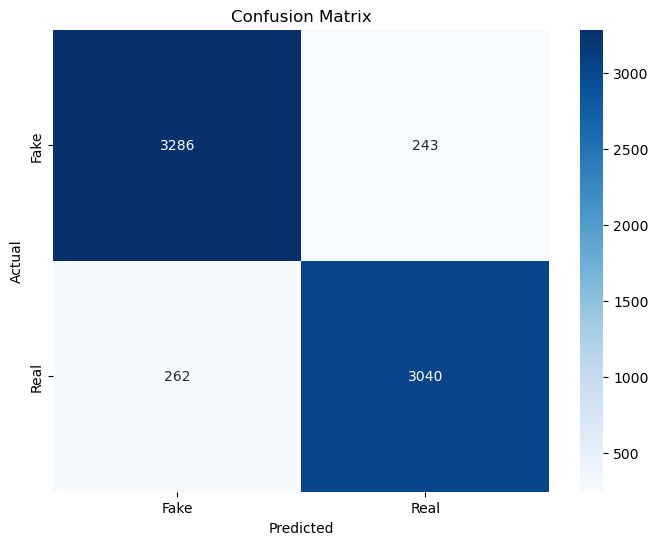

In [12]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_MultinomialNB)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Predict labels for the testing data and write them on a csv file.

In [13]:
X_test_unlabeled = tfidf_vectorizer.transform(test_data['title'].apply(lambda tokens: ' '.join(tokens)))

# Predict labels for the unlabeled data
predicted_labels = MultinomialNB_model.predict(X_test_unlabeled)

test_data['label'] = predicted_labels

# Display the first few rows of the updated testing data
print(test_data.head())

   label                                              title
0      0  [copycat, muslim, terrorist, arrest, assault, ...
1      0  [wow, chicago, protester, catch, camera, admit...
2      1  [germany, fdp, look, fill, schaeubles, big, shoe]
3      0  [mi, school, send, welcome, back, packet, warn...
4      1  [un, seek, massive, aid, boost, amid, rohingya...


In [14]:
# split the label column and title column
test_data_rewrite = pd.read_csv(
    r"../testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB separator
    header=None,
    names=['label', 'title']
)

# write the new labels in place of the placeholders
test_data_rewrite['label'] = predicted_labels

# store the changes in a file
test_data_rewrite.to_csv('Lemmatazing_MultinomialNB_test_data.csv', index=False)

print(test_data_rewrite.head())

   label                                              title
0      0  copycat muslim terrorist arrested with assault...
1      0  wow! chicago protester caught on camera admits...
2      1   germany's fdp look to fill schaeuble's big shoes
3      0  mi school sends welcome back packet warning ki...
4      1  u.n. seeks 'massive' aid boost amid rohingya '...
